<a href="https://colab.research.google.com/github/YuNeziat/Timeless-Correlation-Theory/blob/main/TCT_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeless / Relational Time — Page–Wootters Playground (Colab)

This notebook demonstrates the idea of **timeless dynamics**: globally, there is no time, and dynamics emerge as **correlations** between the subsystems “clock” and “system.”  
Below are 3 experiments:

1. **Ideal case (Page–Wootters):** the conditional state of the system at fixed clock readings coincides with the usual evolution \(e^{-i H_S \tau}|\psi(0)\rangle\).
2. **Noisy correlations and rescaling:** how noise spoils the match, and why reparameterization of time does not change the physics.
3. **Clock detuning:** how the Hamiltonian constraint violation grows and fidelity decreases if the clock is miscalibrated.



# Requirements:
# numpy>=1.20
# scipy>=1.7
# matplotlib>=3.4

In [ ]:

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt




## 1) Ideal Relational Evolution (Page–Wootters)

Globally, we construct the state
\[
|\Psi\rangle = \frac{1}{\sqrt{N}} \sum_k |\tau_k\rangle_C \otimes e^{-i H_S \tau_k}|\psi(0)\rangle_S
\]
and then **condition** on the clock reading \( \tau_k \).  
The fidelity with the ideal evolution should be ≈ 1.0.


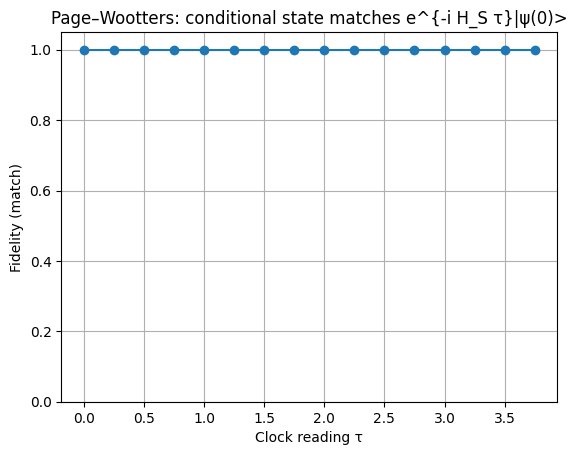

Min/max fidelity: 1.0 1.0000000000000004


In [ ]:
# Parameters
N = 16                 # discrete clock "ticks"
omega = 1.0            # system frequency
dt = 0.25              # clock step (τ_k = k*dt)
tau_vals = np.arange(N) * dt

# Pauli matrices
sx = np.array([[0,1],[1,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)

# System Hamiltonian
H_S = 0.5 * omega * sx

# Initial system state |ψ(0)>
psi0 = np.array([1,0], dtype=complex)

# Build the global state |Ψ>: block for each clock tick
Psi_blocks = np.zeros((N, 2), dtype=complex)
for k, tau in enumerate(tau_vals):
    U = expm(-1j * H_S * tau)
    Psi_blocks[k] = U @ psi0

# Normalize the global state (factor 1/√N)
Psi_blocks /= np.sqrt(N)

# Conditional system states (normalize each block)
def normalize(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

cond_states = np.array([normalize(Psi_blocks[k]) for k in range(N)], dtype=complex)

# Fidelity with the ideal evolution
fidelity = []
for k, tau in enumerate(tau_vals):
    psi_ideal = expm(-1j * H_S * tau) @ psi0
    F = np.abs(np.vdot(psi_ideal, cond_states[k]))**2
    fidelity.append(F)

fidelity = np.array(fidelity)

plt.plot(tau_vals, fidelity, marker='o')
plt.ylim(0.0, 1.05)
plt.xlabel('Clock reading τ')
plt.ylabel('Fidelity (match)')
plt.title('Page–Wootters: conditional state matches e^{-i H_S τ}|ψ(0)>')
plt.grid(True)
plt.show()

print("Min/max fidelity:", float(fidelity.min()), float(fidelity.max()))


## 2a) Fidelity degradation under "noisy" clock–system correlations  

We add a controlled admixture `eps` to the global state and observe how the fidelity decreases.


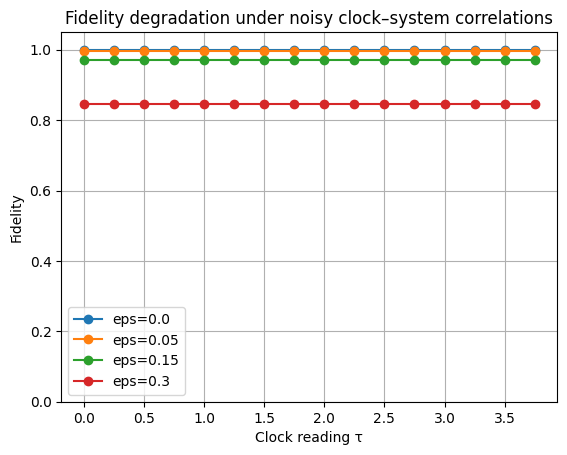

In [ ]:
def build_blocks(N, tau_vals, H_S, psi0, eps=0.0, seed=0):
    rng = np.random.default_rng(seed)
    blocks = np.zeros((N,2), dtype=complex)
    for k, tau in enumerate(tau_vals):
        U = expm(-1j * H_S * tau)
        ideal = U @ psi0
        noise = rng.normal(size=2) + 1j*rng.normal(size=2)
        # Orthogonalize noise against the ideal state
        noise -= (np.vdot(ideal, noise) / np.vdot(ideal, ideal)) * ideal
        v = (1-eps)*ideal + (eps * noise / np.linalg.norm(noise))
        blocks[k] = v
    return blocks / np.sqrt(N)

def cond_states(blocks):
    cs = []
    for k in range(blocks.shape[0]):
        v = blocks[k]; n = np.linalg.norm(v)
        cs.append(v if n==0 else v/n)
    return np.array(cs)

def fidelity_curve(eps):
    blocks = build_blocks(N, tau_vals, H_S, psi0, eps=eps, seed=42)
    states = cond_states(blocks)
    F = []
    for k, tau in enumerate(tau_vals):
        psi_ideal = expm(-1j * H_S * tau) @ psi0
        F.append(np.abs(np.vdot(psi_ideal, states[k]))**2)
    return np.array(F)

eps_list = [0.0, 0.05, 0.15, 0.3]
for eps in eps_list:
    F = fidelity_curve(eps)
    plt.plot(tau_vals, F, marker='o', label=f'eps={eps}')
plt.ylim(0,1.05)
plt.xlabel('Clock reading τ')
plt.ylabel('Fidelity')
plt.title('Fidelity degradation under noisy clock–system correlations')
plt.grid(True); plt.legend(); plt.show()


## 2b) Clock scale shift = reparameterization  

If the time scale is shifted (by δ), then with proper alignment the curves coincide.


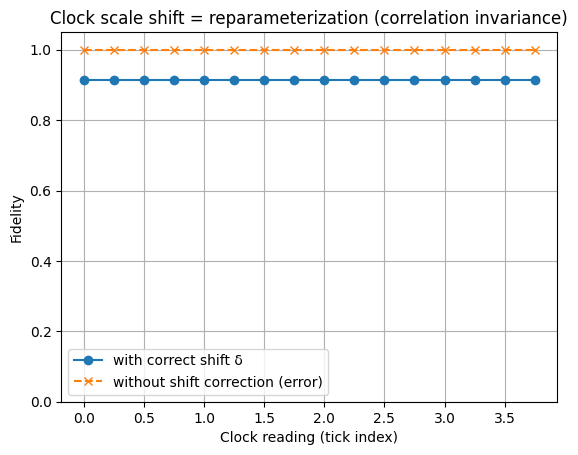

In [ ]:
# Base global state without noise
blocks = np.zeros((N,2), dtype=complex)
for k, tau in enumerate(tau_vals):
    blocks[k] = expm(-1j * H_S * tau) @ psi0
blocks /= np.sqrt(N)

cond_base = cond_states(blocks)

delta = 0.6  # try changing this
tau_shifted = tau_vals + delta

# Comparison: with proper shift (correct) vs without (error)
F_shifted = []
F_wrong = []
for k in range(N):
    psi_shift = expm(-1j * H_S * tau_shifted[k]) @ psi0
    psi_wrong = expm(-1j * H_S * tau_vals[k]) @ psi0
    F_shifted.append(np.abs(np.vdot(psi_shift, cond_base[k]))**2)
    F_wrong.append(np.abs(np.vdot(psi_wrong, cond_base[k]))**2)

plt.plot(tau_vals, F_shifted, marker='o', label='with correct shift δ')
plt.plot(tau_vals, F_wrong, marker='x', linestyle='--', label='without shift correction (error)')
plt.ylim(0,1.05)
plt.xlabel('Clock reading (tick index)')
plt.ylabel('Fidelity')
plt.title('Clock scale shift = reparameterization (correlation invariance)')
plt.grid(True); plt.legend(); plt.show()


## 3) Clock detuning: constraint violation and fidelity loss  

We construct the clock subsystem with a frequency different from the target one (multiplier \(\alpha\)) — and observe:  
1) the norm of the violation \( \|(H_C \otimes I + I \otimes H_S)|\Psi\rangle \| \);  
2) the average fidelity under incorrect interpretation of the clock readings.


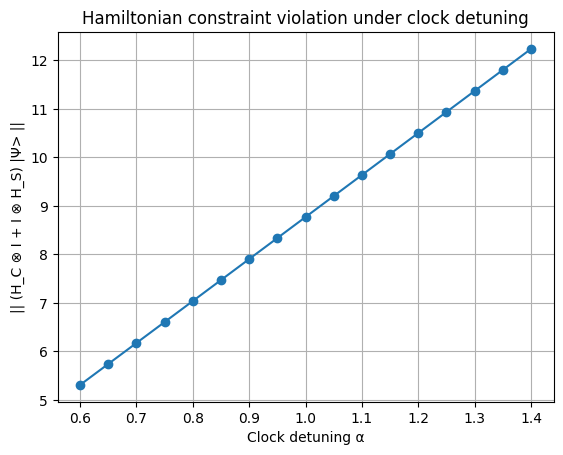

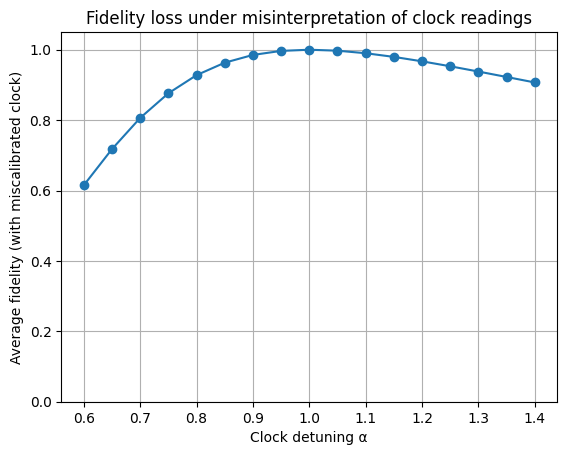

In [ ]:
# Global state |Ψ> (as in Part 1)
blocks_d = np.zeros((N, 2), dtype=complex)
for k, tau in enumerate(tau_vals):
    blocks_d[k] = expm(-1j * H_S * tau) @ psi0
blocks_d /= np.sqrt(N)

# Vector |Ψ> in H_C ⊗ H_S
Psi_vec = np.zeros(N*2, dtype=complex)
for k in range(N):
    e_k = np.zeros(N); e_k[k] = 1.0
    Psi_vec += np.kron(e_k, blocks_d[k])
Psi_vec = Psi_vec / np.linalg.norm(Psi_vec)

I2 = np.eye(2, dtype=complex)

# Clock Hamiltonian H_C(alpha) via DFT diagonalization
def H_clock(alpha=1.0):
    k = np.arange(N)
    m = np.arange(N)
    F = np.exp(2j * np.pi * np.outer(k, m) / N) / np.sqrt(N)
    Omega = 2*np.pi * m / (N*dt) * alpha
    return (F @ np.diag(Omega) @ F.conj().T).astype(complex)

def cond_states_from_blocks(blocks):
    out = []
    for k in range(N):
        v = blocks[k]; n = np.linalg.norm(v)
        out.append(v if n==0 else v/n)
    return np.array(out)

cond_states_d = cond_states_from_blocks(blocks_d)

alphas = np.linspace(0.6, 1.4, 17)
viol_norm = []
fid_misread = []

for alpha in alphas:
    Hc = H_clock(alpha)
    Htot = np.kron(Hc, I2) + np.kron(np.eye(N), H_S)
    resid = Htot @ Psi_vec
    viol_norm.append(np.linalg.norm(resid))

    # Misinterpretation of tick: τ_obs = k * (dt/alpha)
    F_list = []
    for k in range(N):
        tau_obs = k * (dt/alpha)
        psi_ideal = expm(-1j * H_S * tau_obs) @ psi0
        F_list.append(np.abs(np.vdot(psi_ideal, cond_states_d[k]))**2)
    fid_misread.append(np.mean(F_list))

viol_norm = np.array(viol_norm)
fid_misread = np.array(fid_misread)

plt.plot(alphas, viol_norm, marker='o')
plt.xlabel('Clock detuning α')
plt.ylabel('|| (H_C ⊗ I + I ⊗ H_S) |Ψ> ||')
plt.title('Hamiltonian constraint violation under clock detuning')
plt.grid(True)
plt.show()

plt.plot(alphas, fid_misread, marker='o')
plt.ylim(0,1.05)
plt.xlabel('Clock detuning α')
plt.ylabel('Average fidelity (with miscalibrated clock)')
plt.title('Fidelity loss under misinterpretation of clock readings')
plt.grid(True)
plt.show()
